In [1]:
#import everything necessary for eda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../helpers/')

from data import Database
from utils import Helpers

In [13]:
db = Database(host="localhost", database="telecom", user="postgres", password="heisenberg")
df = db.read_table_to_dataframe('xdr_data')
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.304243e+19,4/24/2019 0:00,149.0,4/25/2019 0:00,998.0,86399.0,2.082019e+14,3.369953e+10,3.557301e+13,D88369C,...,5095120.0,11861622.0,7689803.0,6793183.0,491918218.0,14616302.0,656859048.0,11436619.0,45470322.0,515339088.0
1,7.277826e+18,4/24/2019 0:00,862.0,4/25/2019 0:00,814.0,86399.0,2.082014e+14,3.365089e+10,8.654080e+13,D16410A,...,2384664.0,5206279.0,1284910.0,19542046.0,986261.0,4127261.0,246859395.0,9174306.0,42347633.0,18210634.0
2,1.304243e+19,4/24/2019 0:00,50.0,4/25/2019 0:00,54.0,86400.0,2.082014e+14,3.366578e+10,8.637690e+13,L76635A,...,11169871.0,6309070.0,2968645.0,15824189.0,614180878.0,16367798.0,827122316.0,13989557.0,54497130.0,637922880.0
3,1.311448e+19,4/24/2019 0:01,376.0,4/25/2019 0:00,474.0,86353.0,2.082017e+14,3.376005e+10,3.538801e+13,D93137A,...,9836919.0,14194834.0,1987581.0,2320189.0,154169379.0,11096200.0,557824715.0,1724874.0,32846344.0,178595735.0
4,7.277826e+18,4/24/2019 0:01,833.0,4/25/2019 0:01,705.0,86399.0,2.082019e+14,3.366726e+10,8.637690e+13,T26848C,...,20442662.0,17691359.0,18293605.0,1782882.0,270067323.0,3832516.0,104543667.0,12362721.0,36860456.0,321042366.0


In [22]:
#for all the missing values, if they are float, replace the missing values with the mean of the column's values

for column in df.columns:
    if df[column].dtype == 'float64' and df[column].isnull().any():
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
        
df.isnull().sum()
no_null_df = df
no_null_df.isnull().sum()


Bearer Id                                      0
Start                                          1
Start ms                                       0
End                                            1
End ms                                         0
Dur. (ms)                                      0
IMSI                                           0
MSISDN/Number                                  0
IMEI                                           0
Last Location Name                          1153
Avg RTT DL (ms)                                0
Avg RTT UL (ms)                                0
Avg Bearer TP DL (kbps)                        0
Avg Bearer TP UL (kbps)                        0
TCP DL Retrans. Vol (Bytes)                    0
TCP UL Retrans. Vol (Bytes)                    0
DL TP < 50 Kbps (%)                            0
50 Kbps < DL TP < 250 Kbps (%)                 0
250 Kbps < DL TP < 1 Mbps (%)                  0
DL TP > 1 Mbps (%)                             0
UL TP < 10 Kbps (%) 

## Task 4.1

Aggregate, per customer, the following information (treat missing & outliers by replacing by the mean or the mode of the corresponding variable):
Average TCP retransmission
Average RTT
Handset type
Average throughput



In [4]:
task_4_1_columns = [
    'MSISDN/Number',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Handset Type',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)'
]

In [25]:
#Average TCP retransmission in all the data

#first let me select the relevant data and put it in a datafram

task4_1_data = no_null_df[task_4_1_columns]
task4_1_data.isnull().sum()
#we got 0 missing values in the float64 dtype
#so now we do average tcp retransmission 

tcp_retransmission = (
    task4_1_data.groupby('MSISDN/Number')
    .agg({'TCP DL Retrans. Vol (Bytes)': 'mean', 'TCP UL Retrans. Vol (Bytes)': 'mean'})
    .reset_index()
)

#rename the columns
tcp_retransmission.columns = ['MSISDN/Number', 'Avg_TCP_DL_Retrans (MB)', 'Avg_TCP_UL_Retrans (MB)']
tcp_retransmission /= (1024 * 1024)
tcp_retransmission.head()

,MSISDN/Number,Avg_TCP_DL_Retrans (MB),Avg_TCP_UL_Retrans (MB)
0,32044.412348,19.845881,0.724467
1,32044.412378,19.845881,0.724467
2,32044.413100,19.845881,0.724467
3,32044.418175,0.001017,0.724467
4,32044.418923,14.381191,0.372343


And now we do average RTT

In [26]:
#group by msisdn

rtt_data = no_null_df[task_4_1_columns]

rtt_data = (
    task4_1_data.groupby('MSISDN/Number')
    .agg({'Avg RTT DL (ms)': 'mean', 'Avg RTT UL (ms)': 'mean'})
    .reset_index()
)

rtt_data.columns = ['MSISDN/Number', 'Avg_RTT_DL (ms)', 'Avg_RTT_UL (ms)']
rtt_data.head()

,MSISDN/Number,Avg_RTT_DL (ms),Avg_RTT_UL (ms)
0,3.360100e+10,46.000000,0.000000
1,3.360100e+10,30.000000,1.000000
2,3.360100e+10,109.795706,17.662883
3,3.360101e+10,69.000000,15.000000
4,3.360101e+10,57.000000,2.500000


And now for handset type aggregation. We will use the handset with a mod of 0 to fill in the missing handset types and then  

In [28]:
most_freq = task4_1_data['Handset Type'].mode()[0]

task4_1_data['Handset Type'].fillna(most_freq, inplace=True)

#now group by msisdn number
handset = task4_1_data.groupby('MSISDN/Number')['Handset Type'].agg(lambda x: x.mode()[0]).reset_index()
handset.columns = ['MSISDN/Number', 'Most Used Handset Type']
handset.head()
handset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106857 entries, 0 to 106856
Data columns (total 2 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   MSISDN/Number           106857 non-null  float64
 1   Most Used Handset Type  106857 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.6+ MB


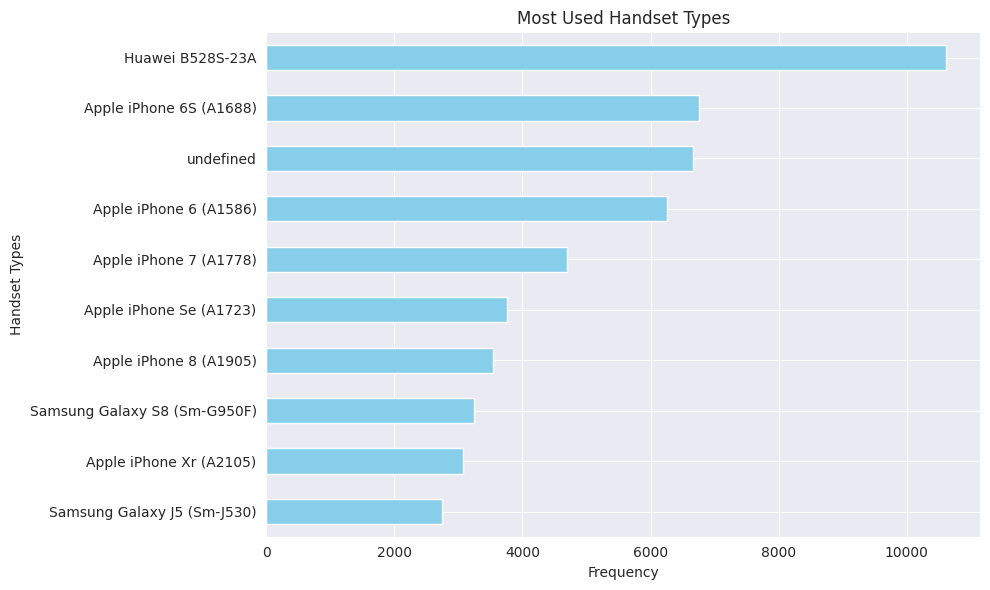

In [44]:
import matplotlib.pyplot as plt

# Assuming handset_data['Most Used Handset Type'] contains the handset types
handset_counts = handset['Most Used Handset Type'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
handset_counts.sort_values().plot(kind='barh', color='skyblue')  # Horizontal bar chart
plt.title('Most Used Handset Types')
plt.xlabel('Frequency')
plt.ylabel('Handset Types')
plt.tight_layout()
plt.show()


Came to decide that "undefined" is something purposely set by the company and not something thatt is null or missing

In [39]:
handset['Most Used Handset Type'].value_counts()

Most Used Handset Type
Huawei B528S-23A                    10616
Apple iPhone 6S (A1688)              6759
undefined                            6669
Apple iPhone 6 (A1586)               6260
Apple iPhone 7 (A1778)               4699
                                    ...  
Wiko Global Sasu Wiko Highway 4G        1
Archos Sa Core 70 3G                    1
Logicom Sa Logicom Id Bot 53+           1
Htc 2Q5W100                             1
Quectel Wireless. Quectel Ec21-E        1
Name: count, Length: 1394, dtype: int64

And now the final task of 4.1: Throughput 


In [50]:
throughput_df = task4_1_data['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']
throughput_df['Avg Throughput (kbps)'] = (throughput_df['Avg Bearer TP DL (kbps)'] + throughput_df['Avg Bearer TP UL (kbps)']) / 2
throughput_df

KeyError: ('Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)')

In [51]:
print(task4_1_data.columns)

Index(['MSISDN/Number', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Handset Type',
       'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)'],
      dtype='object')
